# Nearest Neighbors and Losses

## How parameters affect metric-based loss functions

This notebook demonstrates what a metric-based loss function method looks like, and how different choices of K-nearest neighbors affect processing time and loss.

In [ ]:
import networkx as nx
import osmnx as ox 
import time
from shapely.geometry import Polygon
import os
import ujson as json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from algorithms import mm_utils
import dask

# Remove this when debugging
#import warnings
#warnings.filterwarnings('ignore')

import dask.bag as db

%matplotlib inline
#ox.__version__

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


First we load our test case, as well as the surrounding network.

In [ ]:
tripdata_nodes = gpd.read_file('testcase-square.gpx')
tripdata_nodes = tripdata_nodes.dropna(axis=1, how = 'all')

In [ ]:
# Let's convert the time into UNIX timestamps

from datetime import datetime as dt
import time

tripdata_nodes['time'] = (tripdata_nodes['time'] - pd.Timestamp("1970-01-01").tz_localize("UTC")) // pd.Timedelta("1s")
tripdata_nodes = tripdata_nodes.rename(columns = {'time':'timestamp'})
tripdata_nodes = tripdata_nodes[['ele', 'timestamp', 'geometry']]

# We will need the edges for FMM, so I wrote a helper function to create edges from points
tripdata_edges = mm_utils.point_to_traj(tripdata_nodes, columns = {'ele': 'average',
                                                                  'timestamp':'first'})


In [ ]:
# Let's get the network too

networkgraph = mm_utils.df_to_network(tripdata_nodes, buffer = 0.0005, ntype = 'drive', as_gdf = False)
network_nodes, network_edges = mm_utils.df_to_network(tripdata_nodes, buffer = 0.0005, ntype = 'drive', as_gdf = True)


In [ ]:
knn = mm_utils.get_nearest_edges(tripdata_nodes, network_edges, k_neighbors = 3, r = 0.001)

<AxesSubplot:>

<AxesSubplot:>

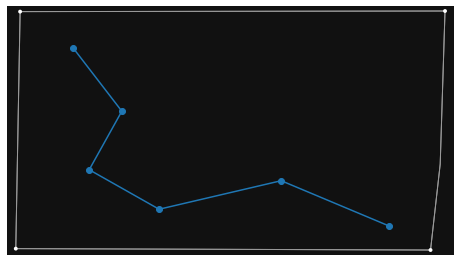

In [ ]:
fig, ax = ox.plot_graph(networkgraph, figsize = (8,8),show=False,close=False)
tripdata_nodes.plot(ax=ax)
tripdata_edges.plot(ax=ax)

In [ ]:
# How many sections should each segment be broken up into?
n = 10 # Segments to interpolate GPS coordinates
m = 25 # Segments to divide network edges into

from algorithms import metric_mm


Now we set up our loss functions.

In [ ]:

def route_inner(distarray):
    return distarray # If we wish to apply a function to the distances within the array, this is where we do it

def route_outer(distarray):
    return 1*(1/np.size(distarray) * np.sum(distarray)) # This is where we 'integrate', and if we need to do anything else, we do it

def gps_inner(distarray):
    return distarray

def gps_outer(distarray):
    return 1*(1/np.size(distarray) * np.sum(distarray))

def wrapper_f(ri,ro,gi,go): # This should return a function composed from the basic functions, that can then be applied onto route and gps data.
    return lambda route, gps : 1*ro(ri(route)) + 1*go(gi(gps))

#loss_function = wrapper_f(route_inner, route_outer, gps_inner, gps_outer)


In [ ]:
%%time

knn1 = 1
knn2 = 5
knnm = 50

sim = metric_mm.Sim(route_inner, route_outer, gps_inner, gps_outer, wrapper_f)
sim.preprocessing(tripdata_edges, network_edges, n=n,m=m)

CPU times: user 430 ms, sys: 7.76 ms, total: 438 ms
Wall time: 437 ms


In [ ]:
%%time

results1 = sim.run(k1=knn1, k2 = knn1, return_full=True, return_results=True)

CPU times: user 4.1 ms, sys: 121 µs, total: 4.22 ms
Wall time: 3.3 ms


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Loss of Combined Edges using 1NN')

Text(0.5, 0.2, 'The ratio of the route losses is 1.958')

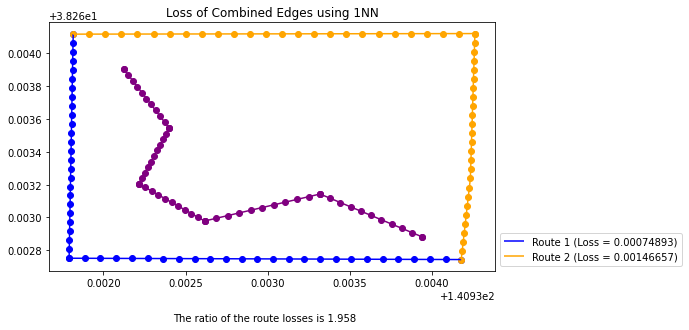

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

results1[0][0].plot(ax=ax, color='blue')
sim.candidate_route_nodes[0].plot(ax=ax, color = 'blue')
results1[0][1].plot(ax=ax, color='orange')
sim.candidate_route_nodes[1].plot(ax=ax, color = 'orange')


tripdata_nodes.plot(ax=ax, color='purple')
sim.trajectory.plot(ax=ax, color='purple')
tripdata_edges.plot(ax=ax,  color='purple')


ax.legend(handles = [ax.collections[0],ax.collections[2]],
          labels = ['Route 1 (Loss = ' + str(results1[1][0])[:10] + ')',
                  'Route 2 (Loss = ' + str(results1[1][1])[:10] + ')'],
          loc = 'lower left', bbox_to_anchor=(1,0))

ax.set_title('Loss of Combined Edges using ' + str(knn1) + 'NN')
fig.text(.5, .2, 'The ratio of the route losses is ' + str(results1[1][1]/results1[1][0])[:5], ha='center')

In [ ]:
%%time

results2 = sim.run(k1=knn2, k2 = knn2, return_full=True, return_results=True)

CPU times: user 4.85 ms, sys: 673 µs, total: 5.52 ms
Wall time: 4.32 ms


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Loss of Combined Edges using 5NN')

Text(0.5, 0.2, 'The ratio of the route losses is 1.899')

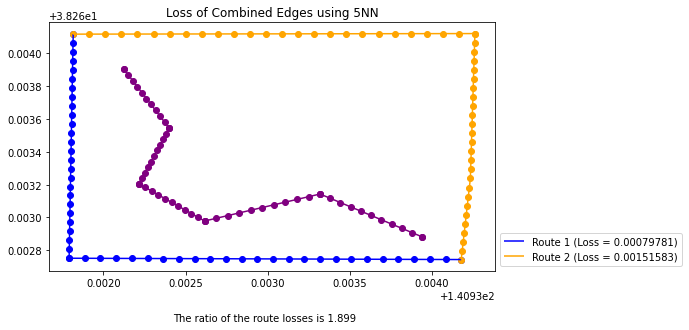

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

results2[0][0].plot(ax=ax, color='blue')
sim.candidate_route_nodes[0].plot(ax=ax, color = 'blue')
results2[0][1].plot(ax=ax, color='orange')
sim.candidate_route_nodes[1].plot(ax=ax, color = 'orange')


tripdata_nodes.plot(ax=ax, color='purple')
sim.trajectory.plot(ax=ax, color='purple')
tripdata_edges.plot(ax=ax,  color='purple')


ax.legend(handles = [ax.collections[0],ax.collections[2]],
          labels = ['Route 1 (Loss = ' + str(results2[1][0])[:10] + ')',
                  'Route 2 (Loss = ' + str(results2[1][1])[:10] + ')'],
          loc = 'lower left', bbox_to_anchor=(1,0))

ax.set_title('Loss of Combined Edges using ' + str(knn2) + 'NN')
fig.text(.5, .2, 'The ratio of the route losses is ' + str(results2[1][1]/results2[1][0])[:5], ha='center')

Notice that the computation time has not significantly increased. However, the ratio between the losses has changed; the two losses are now relatively closer in value to each other.

In [ ]:
%%time

results3 = sim.run(k1=knnm, k2 = knnm, return_full=True, return_results=True)

CPU times: user 2.75 ms, sys: 3.09 ms, total: 5.85 ms
Wall time: 4.46 ms


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Loss of Combined Edges using MaxNN')

Text(0.5, 0.2, 'The ratio of the route losses is 1.452')

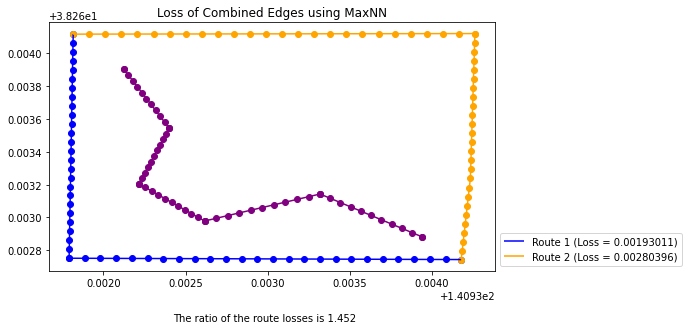

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

results3[0][0].plot(ax=ax, color='blue')
sim.candidate_route_nodes[0].plot(ax=ax, color = 'blue')
results3[0][1].plot(ax=ax, color='orange')
sim.candidate_route_nodes[1].plot(ax=ax, color = 'orange')


tripdata_nodes.plot(ax=ax, color='purple')
sim.trajectory.plot(ax=ax, color='purple')
tripdata_edges.plot(ax=ax,  color='purple')


ax.legend(handles = [ax.collections[0],ax.collections[2]],
          labels = ['Route 1 (Loss = ' + str(results3[1][0])[:10] + ')',
                  'Route 2 (Loss = ' + str(results3[1][1])[:10] + ')'],
          loc = 'lower left', bbox_to_anchor=(1,0))

ax.set_title('Loss of Combined Edges using MaxNN')
fig.text(.5, .2, 'The ratio of the route losses is ' + str(results3[1][1]/results3[1][0])[:5], ha='center')

Even if we compare the distances between all points of the GPS trajectory and the candidate routes, our computation time does not increase significantly compared to previous cases. This indicates that computation time need not be considered when deciding the parameter for k-NN.

However, notice the loss ratio has decreased a lot more. Now there are a lot more 'bad points' being seen in both routes.

There is no reason to expect that at any point Route 2 would ever have less loss than Route 1, so it is not directly a concern. However, it may indicate that high values of k may not best represent the validity of routes. In theory, if values of routes start to become a lot less distinct, you may run into floating point concerns in which we can no longer distinguish the loss between two different routes.

Of course, if k is too small, then outlier points on the GPS trajectory may result in a lower loss for a route than one might expect. One should experiment with different values of k (likely based on number of points and their frequency) within their own dataset to determine what value performs best in a specific case.